## Step 0: Pre-Requirements - Import Modules 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib
from statsmodels.tools.eval_measures import rmse 
from sklearn.preprocessing import MinMaxScaler
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings 
warnings.filterwarnings("ignore")

Using matplotlib backend: agg


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Step 1 : Import data set and draw ACF / PACF plot then choose time lag

Download the data from https://github.com/Marimuthu8421/LSTM-Models/tree/main/data/UK and store it in your local file. Run the below code and click 'Choose Files' then browse your data (.csv file). 

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving UK covid19 train_data.csv to UK covid19 train_data.csv


Import the uploaded data as name 'df' using the function pd.read_csv(). If you are using other data then please change 'UK covid19 train_data.csv' as data file name.

In [ ]:
import pandas as pd
import io
df = pd.read_csv(io.BytesIO(uploaded['UK covid19 train_data.csv']))

# Print variable  names
print(list(df.columns))

# Pring Head of the data
df.head()

['Date', 'Confirmed']


,Date,Confirmed
0,01-05-2021,2226
1,02-05-2021,1819
2,03-05-2021,1429
3,04-05-2021,1515
4,05-05-2021,2082


In [ ]:
# Month  is already in index of df otherwise change it usingthe following code
# change the Month column as Index

df1=df
df1.Date=pd.to_datetime(df.Date)
df1=df1.set_index("Date")
df1.head()

,Confirmed
Date,
2021-01-05,2226
2021-02-05,1819
2021-03-05,1429
2021-04-05,1515
2021-05-05,2082


Plot line graph for Daily cases using the code given below

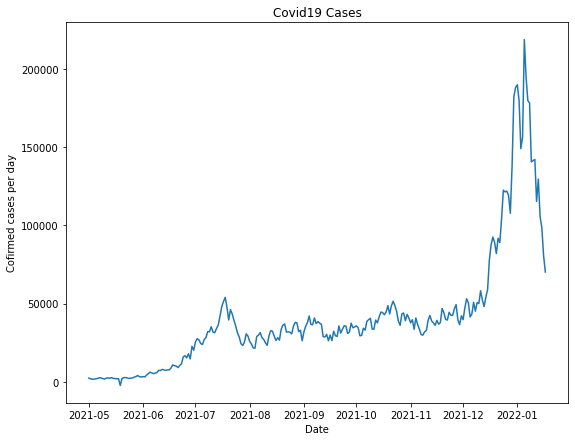

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 7))
ax.plot(df1.index.values, df1['Confirmed'])
ax.set(xlabel="Date",
       ylabel="Cofirmed cases per day",
       title="Covid19 Cases")

plt.show()

Draw ACF / PACF plot using the function accf() / pacf(). Choose the significant lag as the optimal time step which can be used for data pre-processing.

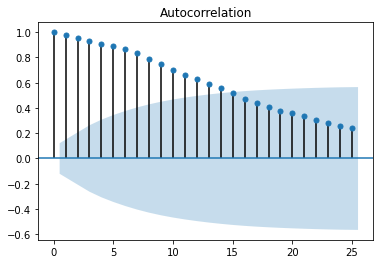

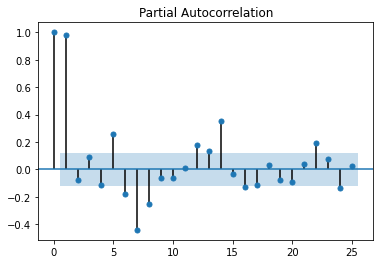

In [ ]:
## Auto correlation and Partial Auto correlation Plot
from statsmodels.graphics.tsaplots import acf, pacf, plot_pacf, plot_acf
from matplotlib import pyplot

import numpy as np
dat=np.array(df1['Confirmed'])

plot_acf(dat)
plot_pacf(dat)
pyplot.show()

## step2: Data pre-processing

We can divide the sequence into input (X) and output (y).
Let {Xi, i=1, 2, 3, …, n} be the daily incident cases. Suppose, lag is three, then the fourth day count depends on previous 3 days (third, second and first) and fifth day count depends on fourth, third, and second day counts, and so on. Therefore, the data should be organized as follows:

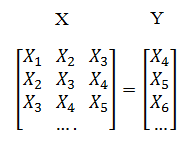

Define the function **prepare_data()** which convert the time series data into X and y.

In [ ]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_steps):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
n_steps = 14 # Choose from the ACF plot

# split into samples
X, y = prepare_data(df1['Confirmed'], n_steps)

print(X.shape)

In [ ]:
# Summarize the data

for i in range(len(X)):
  print(X[i], y[i])

[2381 1907 1671 1649 1946 2144 2613 2490 2047 1770 2357 2474 2284 2656] 2193
[1907 1671 1649 1946 2144 2613 2490 2047 1770 2357 2474 2284 2656 2193] 2027
[1671 1649 1946 2144 2613 2490 2047 1770 2357 2474 2284 2656 2193 2027] 1926
[1649 1946 2144 2613 2490 2047 1770 2357 2474 2284 2656 2193 2027 1926] 1979
[1946 2144 2613 2490 2047 1770 2357 2474 2284 2656 2193 2027 1926 1979] -2364
[ 2144  2613  2490  2047  1770  2357  2474  2284  2656  2193  2027  1926
  1979 -2364] 2135
[ 2613  2490  2047  1770  2357  2474  2284  2656  2193  2027  1926  1979
 -2364  2135] 2694
[ 2490  2047  1770  2357  2474  2284  2656  2193  2027  1926  1979 -2364
  2135  2694] 2702
[ 2047  1770  2357  2474  2284  2656  2193  2027  1926  1979 -2364  2135
  2694  2702] 2523
[ 1770  2357  2474  2284  2656  2193  2027  1926  1979 -2364  2135  2694
  2702  2523] 2092
[ 2357  2474  2284  2656  2193  2027  1926  1979 -2364  2135  2694  2702
  2523  2092] 2362
[ 2474  2284  2656  2193  2027  1926  1979 -2364  2135  2694  

## Step 3: Reorganize the data as in the format of input to the model

The input data X has the shape [samples, timesteps] and it reshaped before feed into model. The input shape of the Simple LSTM model is [samples, timesteps, features] where feature is always one for univariate time series analysis.

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape(X.shape[0], X.shape[1], n_features)
print(X.shape)

(248, 14, 1)


## Step 4: Model Buiilding

Sherstinsky et.al (year) discussed the methodology of the Vanilla LSTM model. This is the simple LSTM configuration model compare to other models with one hidden LSTM layer and output layer. We have developed our own model with one LSTM layer followed by eight dense layers. However, the dense layers can be adjusted based on the model perfomance.

In [ ]:
# define model
model = Sequential()
model.add(LSTM(500, activation='relu', input_shape=(n_steps, n_features)))

#model.add(Dense(10000, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
#model.add(Dense(5000, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
#model.add(Dense(3000, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
#model.add(Dense(2000, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(1000, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(500, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(300, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(200, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(100, activation='relu',kernel_initializer='he_uniform',kernel_regularizer =keras.regularizers.l2( l=0.01)))
model.add(Dense(1))

In [ ]:
# Comppile the model
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 500)               1004000   
                                                                 
 dense_41 (Dense)            (None, 1000)              501000    
                                                                 
 dense_42 (Dense)            (None, 500)               500500    
                                                                 
 dense_43 (Dense)            (None, 300)               150300    
                                                                 
 dense_44 (Dense)            (None, 200)               60200     
                                                                 
 dense_45 (Dense)            (None, 100)               20100     
                                                                 
 dense_46 (Dense)            (None, 1)                

**Call backs**

reuce lr (Learning Rate)-if no  improvement seeing for the patience the learning rate is reuce.

factor - by which the learning eate will be reduce.

patience - # of epochs with no improvement after that the learning rate will reduce

verbose - contain binary 0 quit 1 update message.

mode - auto min max, 
    **min** - LR will reduce when quantity 
monitor has stop decresing;
    **max** -  LR will reduce when quantity monitor has stop incresing;
    **auto** - the direction is automatically infere from the nameof monitor. 

In [ ]:
# Call backs
# reuce lr (Learning Rate)-if no  improvement seeing for the patience the learning rate is reuce
# factor - by which the learning eate will be reduce
# patience - # of epochs with no improvement after that the learning rate will reduce
# verbose - contain binary 0 quit 1 update msg
# mode - auto min max, min - LR will reduce when quantity monitor has stop decresing
#         max -  LR will reduce when quantity monitor has stop incresing
#         auto - the direction is automatically infere from the nameof monitor
# Early stopping  

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

checkpoint=ModelCheckpoint(filepath='best_weights.hdf11', 
                           save_best_only=True, save_weights_only=True)
lr_reduce=ReduceLROnPlateau(monitor='loss',factor=0.3,
                            patience=3,  verbose=2, mode='max')
early_stop=EarlyStopping(monitor='loss',min_delta=0.1, patience=3, mode='min')

## Step 5: Fitting and evaluating the model

Fit a model using the train data and evaluate the performance. The Mean Squared Error (MSE) / Mean Absolute Error (MAE) can be used as the metrics to evaluate model performance of both train and test data. 

In [ ]:
# fit model

model.fit(X, y, epochs=100,batch_size=32, verbose=1,callbacks=[checkpoint,lr_reduce])

Epoch 1/100
8/8 [==============================] - 2s 103ms/step - loss: 953259264.0000 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 1s 102ms/step - loss: 435513056.0000 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 1s 102ms/step - loss: 441114304.0000 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 610081984.0000WARNING:tensorflow:Can save best model only with val_loss available, skipping.

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
8/8 [==============================] - 1s 103ms/step - loss: 610081984.0000 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 1s 104ms/step - loss: 266566304.0000 - lr: 3.0000e-04
Epoch 6/100
8/8 [==============================] - 1s 104ms/step - loss: 245019744.0000 - lr: 3.0000e-04
Epoch 7/100
8/8 [==============================] - ETA: 0s - loss: 170527408.0000WARNING:tensorflow:Can save best model only with val_loss available, skippin

In [ ]:
# Predict the data for training data set.

y_hat=model.predict(X, verbose=1)
print(y_hat)

8/8 [==============================] - 0s 33ms/step
[[  2009.8568]
 [  2545.062 ]
 [  2286.7783]
 [  2051.663 ]
 [  2013.526 ]
 [  1073.6398]
 [  1033.3933]
 [  1228.4061]
 [  1384.1301]
 [  1569.7446]
 [  1760.2484]
 [  1947.4998]
 [  1949.9823]
 [  2356.4285]
 [  2572.73  ]
 [  2953.085 ]
 [  2928.5557]
 [  3754.9797]
 [  3361.9126]
 [  3646.75  ]
 [  3453.587 ]
 [  4345.783 ]
 [  5091.1763]
 [  4443.42  ]
 [  5470.599 ]
 [  4875.526 ]
 [  6486.278 ]
 [  7855.647 ]
 [  7155.9736]
 [  7116.91  ]
 [  7149.7925]
 [  8342.818 ]
 [  8084.2437]
 [  7682.37  ]
 [ 10155.446 ]
 [  8435.944 ]
 [ 10671.517 ]
 [  8022.5254]
 [  9436.507 ]
 [ 10385.256 ]
 [ 11681.45  ]
 [ 13509.246 ]
 [ 12754.257 ]
 [ 12835.074 ]
 [ 15942.712 ]
 [ 13947.985 ]
 [ 19336.613 ]
 [ 20118.025 ]
 [ 21121.842 ]
 [ 19238.14  ]
 [ 26074.707 ]
 [ 21762.125 ]
 [ 22094.516 ]
 [ 25533.062 ]
 [ 24318.535 ]
 [ 26279.957 ]
 [ 31364.287 ]
 [ 33059.992 ]
 [ 32790.547 ]
 [ 32143.197 ]
 [ 36315.375 ]
 [ 43298.89  ]
 [ 37987.453 ]
 [ 

In [ ]:
# Merge the predicted data with the data set

n_steps=14
df_pred=pd.DataFrame.from_records(y_hat, columns=['Predicted'])
df_pred=df_pred.reset_index(drop=True)
print(df_pred)

df_actual= pd.DataFrame(dat[n_steps:len(dat)], columns=['Actual'])
df_actual=df_actual.reset_index(drop=True)
#print(df_actual)

Date=df.iloc[n_steps:,0]
Date=Date.reset_index(drop=True)
#print(Date)

data=pd.concat ([Date,df_actual,df_pred],axis=1)
#print(type(data))
#print(data.shape)
print(data)

         Predicted
0      2531.975586
1      2433.772705
2      2364.539307
3      2327.416260
4      2204.413574
..             ...
243  131215.296875
244  100171.523438
245  114058.000000
246   97503.757812
247  103697.335938

[248 rows x 1 columns]
     Actual
0      2193
1      2027
2      1926
3      1979
4     -2364
..      ...
243  129544
244  105679
245   98578
246   80725
247   70160

[248 rows x 1 columns]
0       15
1       16
2       17
3       18
4       19
      ... 
243    258
244    259
245    260
246    261
247    262
Name: Days, Length: 248, dtype: int64
<class 'pandas.core.frame.DataFrame'>
(248, 3)
     Days  Actual      Predicted
0      15    2193    2531.975586
1      16    2027    2433.772705
2      17    1926    2364.539307
3      18    1979    2327.416260
4      19   -2364    2204.413574
..    ...     ...            ...
243   258  129544  131215.296875
244   259  105679  100171.523438
245   260   98578  114058.000000
246   261   80725   97503.757812
247   262  

**Evaluation Metrics for traning data set.**



In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

R2=r2_score(df_actual, df_pred)
print('R Squared: ', R2)

mae=mean_absolute_error(df_actual, df_pred)
print('Mean Absolute Error: ', mae)

mse=mean_squared_error(df_actual, df_pred)
print('Mean Squared Error: ', mse)

R Squared:  0.919914964774448
Mean Absolute Error:  6210.918817458614
Mean Squared Error:  123014845.79469736


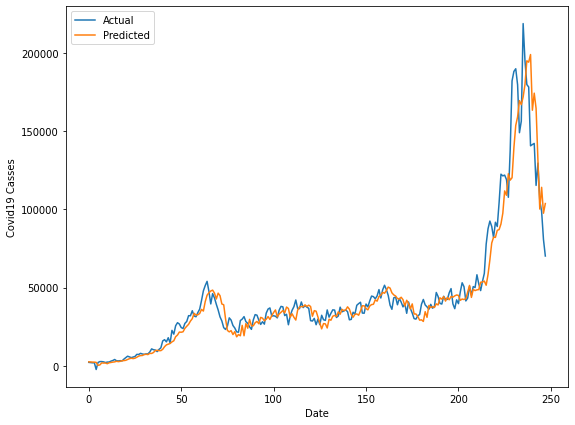

In [ ]:
# Plot the observed and predicted cases
ax=df_actual.plot(label='Observed', figsize=(9,7))
df_pred.plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Covid19 Casses')
plt.legend()
plt.show()

## Step 6: Future Preiction

In order to predict the future value, we have to feed past data as the input. In the absence of past value we can use our predicted value of the corresponding day as the input. The Python code for all the above steps are given in the appendix for the future work.

In [ ]:
# Future Prediction

predictions=model.predict(X,verbose=1)

# Length of future day you wanted to predict
future_time_steps=30

x1=X[-1:,:,:]  # Take last input
x1=x1.astype('float64') 

p1=predictions[-1:]  # take last output

for i  in range(future_time_steps):
  x2=np.array([[x1[0][1],x1[0][2],x1[0][3],x1[0][4], x1[0][5], x1[0][6],x1[0][7],x1[0][8], x1[0][9], x1[0][10],x1[0][11], x1[0][12],x1[0][13], p1]], dtype=np.float)
  #x2=np.array([[x1[0][1],x1[0][2], p1]], dtype=np.float)
 
  p2=model.predict(x2, verbose=1)
  predictions=np.append(predictions, p2)
  x1=x2
  p1=p2

yhat=predictions
yhat=np.reshape(yhat, (-1,1))

df_pred=pd.DataFrame.from_records(yhat, columns=['Predicted'])
df_pred=df_pred.reset_index(drop=True)

df_actual=df[6+n_steps:len(df)]

df_actual=df_actual.reset_index(drop=True)

1/1 [==============================] - 0s 18ms/step


In [ ]:
# Concatinate the predicted data with observed data

Predicted_data=pd.concat ([df_actual,df_pred],axis=1)
print(type(Predicted_data))
print(Predicted_data.shape)
print(Predicted_data)

<class 'pandas.core.frame.DataFrame'>
(278, 5)
     Days       Date  Confirmed  Cumulative_cases     Predicted
0    21.0 2021-05-21     2694.0         4455225.0   2531.975586
1    22.0 2021-05-22     2702.0         4457927.0   2433.772705
2    23.0 2021-05-23     2523.0         4460450.0   2364.539307
3    24.0 2021-05-24     2092.0         4462542.0   2327.416260
4    25.0 2021-05-25     2362.0         4464904.0   2204.413574
..    ...        ...        ...               ...           ...
273   NaN        NaT        NaN               NaN  12086.626953
274   NaN        NaT        NaN               NaN  13143.063477
275   NaN        NaT        NaN               NaN  13496.420898
276   NaN        NaT        NaN               NaN  11299.287109
277   NaN        NaT        NaN               NaN   9236.153320

[278 rows x 5 columns]


## Step 7: Download the data

Write the Predicted data as .csv file and download it  for future purpose

In [ ]:
from google.colab import files
Predicted_data.to_csv('UK -COVID-19 Prediction_simple LSTM 22Jan22.csv') 
files.download('UK -COVID-19 Prediction_simple LSTM 22Jan22.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>